In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
%matplotlib inline


In [13]:
df = pd.read_csv('../data/data.csv', encoding='ISO-8859-1')
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalAmount'] > 0]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
fraud_df = df[['CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice', 'TotalAmount']].copy()

# Aggregate features per invoice
transaction_df = fraud_df.groupby(['InvoiceNo', 'CustomerID']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalAmount': 'sum'
}).reset_index()

transaction_df.head()


,InvoiceNo,CustomerID,Quantity,UnitPrice,TotalAmount
0,536365,17850.0,40,3.910000,139.12
1,536366,17850.0,12,1.850000,22.20
2,536367,13047.0,83,4.853333,278.73
3,536368,13047.0,15,4.775000,70.05
4,536369,13047.0,3,5.950000,17.85


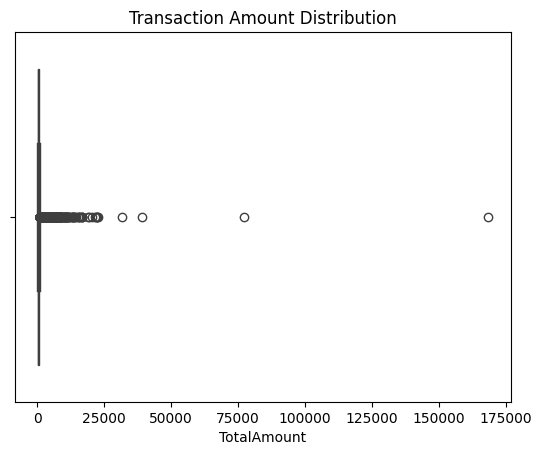

In [15]:
sns.boxplot(x=transaction_df['TotalAmount'])
plt.title('Transaction Amount Distribution')
plt.show()


In [16]:
features = df[['Quantity', 'UnitPrice', 'TotalAmount']]
features.describe()


,Quantity,UnitPrice,TotalAmount
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,22.397000
std,179.331775,22.097877,309.071041
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [17]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(features)


In [18]:
frauds = df[df['anomaly_score'] == -1]
print(f"🔍 Number of potential frauds detected: {len(frauds)}")
frauds.head()



🔍 Number of potential frauds detected: 3965


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,anomaly_score
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100.0,United Kingdom,350.40,-1
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029.0,United Kingdom,733.44,-1
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,647.04,-1
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,647.04,-1
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029.0,United Kingdom,626.40,-1


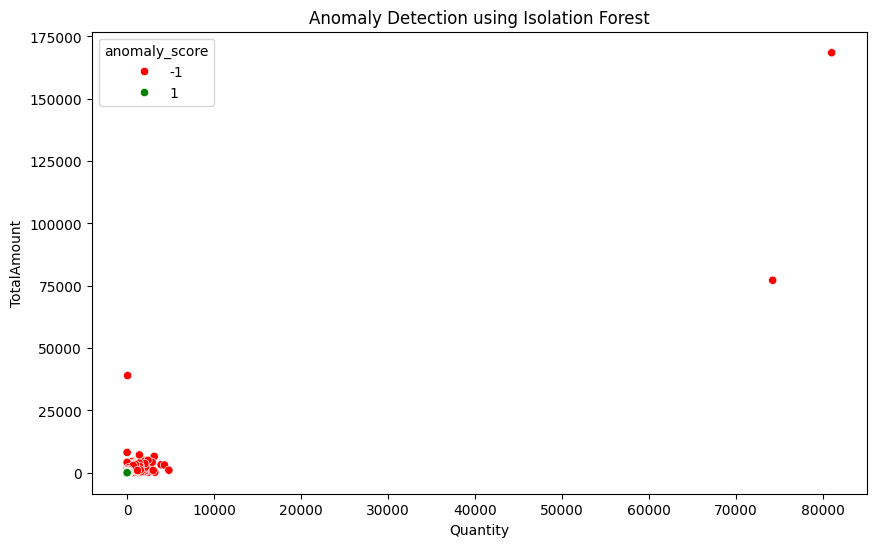

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Quantity', y='TotalAmount', hue='anomaly_score', palette={1:'green', -1:'red'})
plt.title("Anomaly Detection using Isolation Forest")
plt.show()


In [20]:
# Save fraud transactions
frauds.to_csv("../outputs/potential_frauds.csv", index=False)


 used Isolation Forest to detect ~1% of orders that look suspicious. These may include bulk purchases, negative unit prices, or unusual patterns. 